<a href="https://colab.research.google.com/github/himanshu-kr-jha/Projects/blob/main/tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install tsplib95

In [15]:
import numpy as np
import random
import time
import tsplib95
import pandas as pd

# Function to calculate tour distance
def tour_distance(tour, problem):
    dist = 0
    num_nodes = len(tour)
    for i in range(num_nodes):
        dist += problem.get_weight(tour[i], tour[(i + 1) % num_nodes])
    return dist

# Basic Cuckoo Search Algorithm
def basic_cuckoo_search(problem, runs=10, population_size=20, max_iterations=100):
    num_nodes = problem.dimension
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration)
            new_population = []
            for tour in population:
                cuckoo = np.copy(tour)
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                new_population.append(cuckoo)

            # Replace worst solutions with new ones
            population = np.array(new_population)

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time

# Improved Cuckoo Search using Dynamic Cuckoo Search (DCS)
def dcs_cuckoo_search(problem, runs=10, population_size=20, max_iterations=100, initial_step_size=0.1, decay_rate=0.95):
    num_nodes = problem.dimension
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        # Initialize step sizes
        step_sizes = np.full(population_size, initial_step_size)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration) with dynamic step size
            new_population = []
            for i, tour in enumerate(population):
                cuckoo = np.copy(tour)
                # Calculate step size
                step_size = step_sizes[i]
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                # Update step size using dynamic cuckoo search
                if random.random() < step_size:
                    # Replace a randomly selected element by another randomly selected element
                    idx3, idx4 = np.random.choice(num_nodes, 2, replace=False)
                    cuckoo[idx3] = cuckoo[idx4]
                    step_size *= decay_rate
                new_population.append(cuckoo)
                step_sizes[i] = step_size

            # Replace worst solutions with new ones
            population = np.array(new_population)

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time


In [16]:
import os
import tsplib95
import numpy as np
import random
import time
import pandas as pd

# Function to get list of files in a folder
def get_files_in_folder(folder_path):
    files = []
    for file in os.listdir(folder_path):
        if file.endswith(".tsp"):  # Adjust file extension as needed
            files.append(os.path.join(folder_path, file))
    return files

# Function to run both algorithms for multiple files and create a dataframe
def run_algorithms_for_files(files):
    results = []
    for file_path in files:
        print(file_path)
        problem = tsplib95.load(file_path)
        num_nodes = problem.dimension

        # Run basic Cuckoo Search
        basic_stats = basic_cuckoo_search(problem, num_nodes)

        # Run Improved Cuckoo Search using Dynamic Cuckoo Search (DCS)
        improved_stats = dcs_cuckoo_search(problem, num_nodes)

        # Append results for this file
        results.append({
            'File': file_path.split('/')[-1].split('.')[0],
            'Basic Best Distance': basic_stats[0],
            'Basic Average Distance': basic_stats[1],
            'Basic Worst Distance': basic_stats[2],
            'Basic P_Dav(%)': basic_stats[3],
            'Basic P_Dbest(%)': basic_stats[4],
            'Basic Time (s)': basic_stats[5],
            'Improved Best Distance': improved_stats[0],
            'Improved Average Distance': improved_stats[1],
            'Improved Worst Distance': improved_stats[2],
            'Improved P_Dav(%)': improved_stats[3],
            'Improved P_Dbest(%)': improved_stats[4],
            'Improved Time (s)': improved_stats[5]
        })

    return pd.DataFrame(results)

# Function to calculate tour distance
def tour_distance(tour, problem):
    dist = 0
    num_nodes = len(tour)
    for i in range(num_nodes):
        dist += problem.get_weight(tour[i], tour[(i + 1) % num_nodes])
    return dist

# Basic Cuckoo Search Algorithm
def basic_cuckoo_search(problem, num_nodes, runs=10, population_size=20, max_iterations=100):
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration)
            new_population = []
            for tour in population:
                cuckoo = np.copy(tour)
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                new_population.append(cuckoo)

            # Replace worst solutions with new ones
            population = np.array(new_population)

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time

# Improved Cuckoo Search using Dynamic Cuckoo Search (DCS)
def dcs_cuckoo_search(problem, num_nodes, runs=10, population_size=20, max_iterations=100, initial_step_size=0.1, decay_rate=0.95):
    best_solutions = []
    all_distances = []
    start_time = time.time()

    for _ in range(runs):
        # Generate initial population
        population = np.tile(np.arange(1, num_nodes + 1), (population_size, 1))
        np.apply_along_axis(np.random.shuffle, 1, population)

        # Initialize step sizes
        step_sizes = np.full(population_size, initial_step_size)

        for _ in range(max_iterations):
            # Evaluate fitness of each solution
            fitness_values = np.apply_along_axis(lambda x: tour_distance(x, problem), 1, population)

            # Find the best solution
            current_best_idx = np.argmin(fitness_values)
            current_best_distance = fitness_values[current_best_idx]

            # Store the best solution and its distance
            best_solutions.append(population[current_best_idx])
            all_distances.append(current_best_distance)

            # Generate new solutions by random walk (migration) with dynamic step size
            new_population = []
            for i, tour in enumerate(population):
                cuckoo = np.copy(tour)
                # Calculate step size
                step_size = step_sizes[i]
                # Perform random walk (swap two cities)
                idx1, idx2 = np.random.choice(num_nodes, 2, replace=False)
                cuckoo[idx1], cuckoo[idx2] = cuckoo[idx2], cuckoo[idx1]
                # Update step size using dynamic cuckoo search
                if random.random() < step_size:
                    # Replace a randomly selected element by another randomly selected element
                    idx3, idx4 = np.random.choice(num_nodes, 2, replace=False)
                    cuckoo[idx3] = cuckoo[idx4]
                    step_size *= decay_rate
                new_population.append(cuckoo)
                step_sizes[i] = step_size

            # Replace worst solutions with new ones
            population = np.array(new_population)

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate statistics
    best_distance = min(all_distances)
    average_distance = np.mean(all_distances)
    worst_distance = max(all_distances)
    p_dav = (average_distance - best_distance) / best_distance * 100
    p_dbest = (worst_distance - best_distance) / best_distance * 100

    return best_distance, average_distance, worst_distance, p_dav, p_dbest, execution_time

# Get list of files in the folder
folder_path = "/content/drive/MyDrive/tsp_problem"  # Specify your folder path here
files = get_files_in_folder(folder_path)

# Run algorithms for the file
print(files)
result_df = run_algorithms_for_files(files)


['/content/drive/MyDrive/tsp_problem/ch130.tsp', '/content/drive/MyDrive/tsp_problem/ch150.tsp', '/content/drive/MyDrive/tsp_problem/tsp225.tsp', '/content/drive/MyDrive/tsp_problem/u159.tsp', '/content/drive/MyDrive/tsp_problem/burma14.tsp', '/content/drive/MyDrive/tsp_problem/a280.tsp', '/content/drive/MyDrive/tsp_problem/bayg29.tsp', '/content/drive/MyDrive/tsp_problem/att48.tsp', '/content/drive/MyDrive/tsp_problem/kroB200.tsp', '/content/drive/MyDrive/tsp_problem/eil101.tsp', '/content/drive/MyDrive/tsp_problem/kroA100.tsp', '/content/drive/MyDrive/tsp_problem/pr76.tsp', '/content/drive/MyDrive/tsp_problem/pr226.tsp', '/content/drive/MyDrive/tsp_problem/gil262.tsp']
/content/drive/MyDrive/tsp_problem/ch130.tsp
/content/drive/MyDrive/tsp_problem/ch150.tsp
/content/drive/MyDrive/tsp_problem/tsp225.tsp
/content/drive/MyDrive/tsp_problem/u159.tsp
/content/drive/MyDrive/tsp_problem/burma14.tsp
/content/drive/MyDrive/tsp_problem/a280.tsp
/content/drive/MyDrive/tsp_problem/bayg29.tsp
/co

In [17]:
result_df

,File,Basic Best Distance,Basic Average Distance,Basic Worst Distance,Basic P_Dav(%),Basic P_Dbest(%),Basic Time (s),Improved Best Distance,Improved Average Distance,Improved Worst Distance,Improved P_Dav(%),Improved P_Dbest(%),Improved Time (s)
0,ch130,39760,43313.506,45441,8.937389,14.288229,36.970364,40072,42989.589,45527,7.280867,13.612997,14.049062
1,ch150,47713,50616.014,53180,6.084325,11.458093,17.240564,47629,50486.870,52682,6.000273,10.609083,16.346947
2,tsp225,37106,39070.881,40291,5.295319,8.583517,23.192544,36832,39039.565,40317,5.993606,9.461881,24.747621
3,u159,377616,416593.576,439843,10.322014,16.478910,18.370697,387336,417592.145,437418,7.811343,12.929859,17.680259
4,burma14,4099,5314.507,6248,29.653745,52.427421,2.418184,2616,4606.679,5992,76.096292,129.051988,2.455423
5,a280,31009,32256.491,33472,4.022997,7.942855,29.955817,30567,32239.912,33346,5.472935,9.091504,30.549777
6,bayg29,3418,4065.550,4487,18.945290,31.275600,4.232217,3172,3953.994,4438,24.653026,39.911728,3.342486
7,att48,35700,43203.850,47337,21.019188,32.596639,5.411474,34511,42766.413,47601,23.921106,37.929935,6.484124
8,kroB200,297758,311571.907,324436,4.639307,8.959625,21.022371,289415,311081.152,325182,7.486188,12.358378,22.317300
9,eil101,2959,3173.830,3367,7.260223,13.788442,11.594500,2911,3148.868,3350,8.171350,15.080728,11.634253


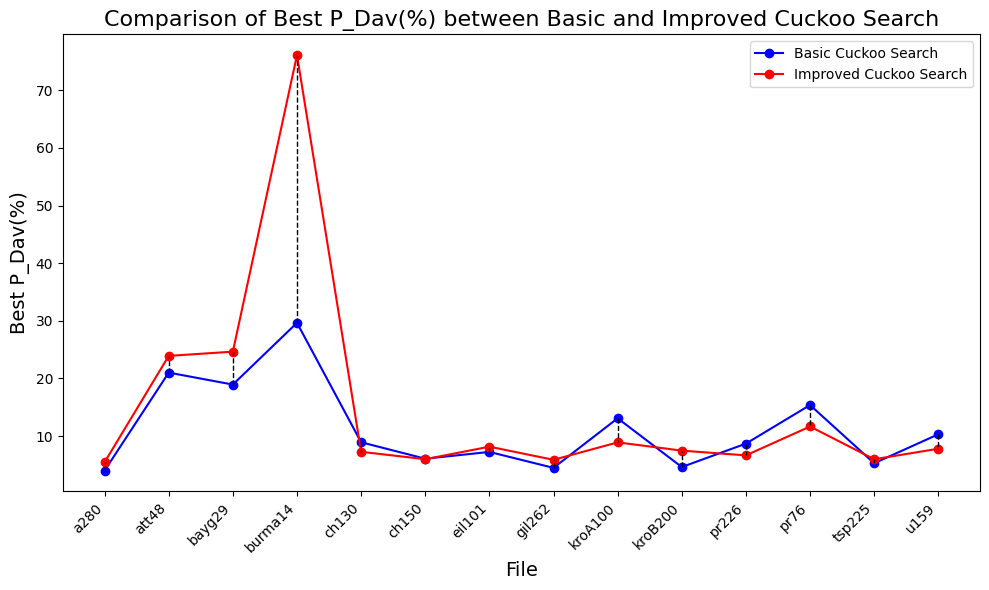

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Extracting data for plotting
sorted_result_df = result_df.sort_values(by='File')  # Sorting the DataFrame

files = sorted_result_df['File']
basic_pdav_best = sorted_result_df['Basic P_Dav(%)']
improved_pdav_best = sorted_result_df['Improved P_Dav(%)']

# Plotting
plt.figure(figsize=(10, 6))

# Plotting basic Cuckoo Search
plt.plot(files, basic_pdav_best, marker='o', color='b', label='Basic Cuckoo Search', linestyle='-')

# Plotting improved Cuckoo Search
plt.plot(files, improved_pdav_best, marker='o', color='r', label='Improved Cuckoo Search', linestyle='-')

# Adding trendline between basic and improved
for i in range(len(files)):
    plt.plot([files[i], files[i]], [basic_pdav_best[i], improved_pdav_best[i]], color='black', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('File', fontsize=14)
plt.ylabel('Best P_Dav(%)', fontsize=14)
plt.title('Comparison of Best P_Dav(%) between Basic and Improved Cuckoo Search', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Showing the plot
plt.tight_layout()
plt.show()
